# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


filename_features = "UCI HAR Dataset/features.txt"
filename_labels = "UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "UCI HAR Dataset/train/y_train.txt"

filename_subtest = "UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "UCI HAR Dataset/test/X_test.txt"
filename_ytest = "UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze("columns")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze("columns")
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze("columns")
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [2]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: user 247 ms, sys: 17.5 ms, total: 264 ms
Wall time: 263 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [3]:
# Realizando a PCA sem padronização
pca = PCA()
X_train_pca = pca.fit(X_train)

# Realizando a PCA com as características padronizadas
pca_pad = PCA()
X_train_pad_pca = pca_pad.fit(X_train_pad)

# Calculando a variância explicada por cada componente
var_exp = pca.explained_variance_
var_exp_pad = pca_pad.explained_variance_

# Calculando a variância explicada acumulada por componente
var_cum = np.cumsum(var_exp) / np.sum(var_exp)
var_cum_pad = np.cumsum(var_exp_pad) / np.sum(var_exp_pad)

# Calculando a porcentagem de variância explicada por cada componente
var_exp_per = pca.explained_variance_ratio_
var_exp_per_pad = pca_pad.explained_variance_ratio_

# Calculando a porcentagem de variância explicada acumulada por componente
var_cum_per = pca.explained_variance_ratio_.cumsum()
var_cum_per_pad = pca_pad.explained_variance_ratio_.cumsum()

# Encontrando o número de componentes necessários para explicar 90% da variância
num_comp = (pca.explained_variance_ratio_.cumsum()<.90).sum()+1
num_comp_pad = np.argmax(var_cum_per_pad >= 0.90) + 1

# Imprimindo os resultados conforme necessário
print(f"Número de componentes para explicar 90% da variância (sem padronização): {num_comp}")
print(f"Número de componentes para explicar 90% da variância (com padronização): {num_comp_pad}")

Número de componentes para explicar 90% da variância (sem padronização): 34
Número de componentes para explicar 90% da variância (com padronização): 63


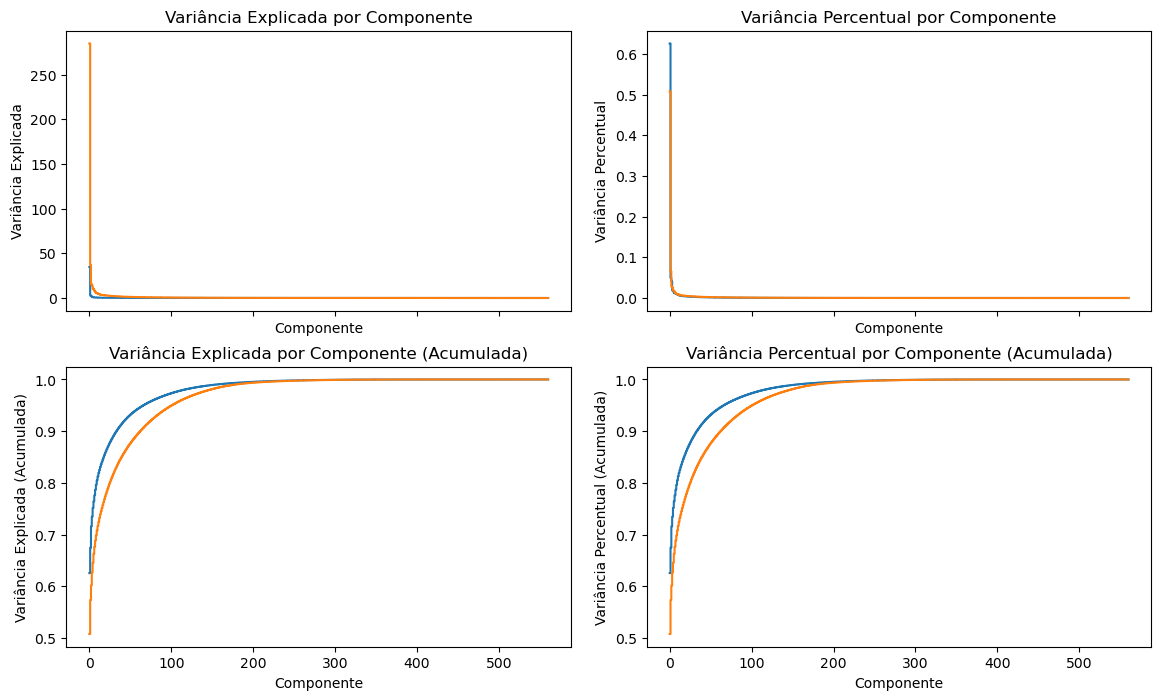

In [4]:
# Plotando o gráfico
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14,8))
plt.subplots_adjust(hspace=.2, wspace=.15)

ax[0, 0].set_xlabel("Componente")
ax[0, 0].set_ylabel("Variância Explicada")
ax[0, 0].set_title("Variância Explicada por Componente")
ax[0, 0].plot(var_exp, label="Não padronizado",    drawstyle="steps-post")
ax[0, 0].plot(var_exp_pad, label="Padronizado", drawstyle="steps-post")

ax[1, 0].set_xlabel("Componente")
ax[1, 0].set_ylabel("Variância Explicada (Acumulada)")
ax[1, 0].set_title("Variância Explicada por Componente (Acumulada)")
ax[1, 0].plot(var_cum, label="Não padronizado",    drawstyle="steps-post")
ax[1, 0].plot(var_cum_pad, label="Padronizado", drawstyle="steps-post")

ax[0, 1].set_xlabel("Componente")
ax[0, 1].set_ylabel("Variância Percentual")
ax[0, 1].set_title("Variância Percentual por Componente")
ax[0, 1].plot(var_exp_per, label="Não padronizado",    drawstyle="steps-post")
ax[0, 1].plot(var_exp_per_pad, label="Padronizado", drawstyle="steps-post")

ax[1, 1].set_xlabel("Componente")
ax[1, 1].set_ylabel("Variância Percentual (Acumulada)")
ax[1, 1].set_title("Variância Percentual por Componente (Acumulada)")
ax[1, 1].plot(var_cum_per, label="Não padronizado",    drawstyle="steps-post")
ax[1, 1].plot(var_cum_per_pad, label="Padronizado", drawstyle="steps-post")

plt.show()

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [5]:
# Padronizando os dados de teste
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)

# Transformando os dados de teste padronizados pelo mesmo PCA
X_test_pad_pca = pca_pad.transform(X_test_pad)

# Criando o modelo de Árvore de Decisão com 10 componentes principais (sem padronização)
clf_no_pca = DecisionTreeClassifier(random_state=23, ccp_alpha=0.001).fit(X_train.iloc[:, :10], y_train)

# Criando o modelo de Árvore de Decisão com 10 componentes principais (com padronização)
clf_with_pca = DecisionTreeClassifier(random_state=23, ccp_alpha=0.001).fit(X_train_pad.iloc[:, :10], y_train)

# Calculando a acurácia nos dados de treinamento e teste para o modelo sem padronização
train_score_no_pca = clf_no_pca.score(X_train.iloc[:, :10], y_train)
test_score_no_pca = clf_no_pca.score(X_test.iloc[:, :10], y_test)

# Calculando a acurácia nos dados de treinamento e teste para o modelo com padronização
train_score_with_pca = clf_with_pca.score(X_train_pad.iloc[:, :10], y_train)
test_score_with_pca = clf_with_pca.score(X_test_pad.iloc[:, :10], y_test)

# Imprimindo os resultados
print("Árvore de Decisão com 10 componentes principais (sem padronização)")
print(f'Acurácia na base de treino: {train_score_no_pca*100:.2f}')
print(f'Acurácia na base de teste: {test_score_no_pca*100:.2f}\n')

print("Árvore de Decisão com 10 componentes principais (com padronização)")
print(f'Acurácia na base de treino: {train_score_with_pca*100:.2f}')
print(f'Acurácia na base de teste: {test_score_with_pca*100:.2f}')


Árvore de Decisão com 10 componentes principais (sem padronização)
Acurácia na base de treino: 72.58
Acurácia na base de teste: 61.38

Árvore de Decisão com 10 componentes principais (com padronização)
Acurácia na base de treino: 72.58
Acurácia na base de teste: 56.12


<span style="color: darkolivegreen;">Ambas as abordagens alcançaram acurácias semelhantes na base de treinamento. No entanto, na base de teste, a árvore de decisão sem padronização obteve uma acurácia ligeiramente superior (61.38%) em comparação com o modelo com padronização (56.12%). Isso sugere que a padronização pode ter influenciado a capacidade do modelo em generalizar para dados de teste não vistos, resultando em um desempenho levemente inferior.</span>
